In [19]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from numba.types import pyobject
import numba

## Defining the class

In [20]:
@jit(nopython=True)
def force(q):
    F = q - q**3
    return F

@jit(nopython=True)
def A_step( qp , h , factor=1):
    q,p = qp

    q = q + h*p*factor

    return [q,p]

@jit(nopython=True)
def B_step( qp , h, factor=1):
    q,p = qp

    F = q - q**3

    p = p + h*F*factor

    return [q,p]


@jit(nopython=True)
def O_step( qp , h,gamma, factor=1):
    q,p = qp

    alpha = np.exp(-h*gamma)

    R = np.random.randn( q.size ).reshape( q.shape)
    p = np.exp(- gamma*h *factor)*p+ np.sqrt(1-np.exp(-gamma*h))*R

    return [q,p]

@jit(nopython=True)
def obabo_step(q,p,h,gamma,beta):
    qp = [q,p]  #this just translates the separate q and p vectors
                #into a single vector composed from the pair.
    qp = O_step( qp, h, gamma, 0.5)
    qp = B_step( qp, h,0.5)
    qp = A_step(qp , h )
    qp = B_step( qp, h,0.5)
    qp = O_step( qp, h, gamma,  0.5)

    q,p = qp
    return q , p


In [21]:
 q_traj= np.array([[]])
numba.typeof(q_traj)

array(float64, 2d, C)

# Defining a class for the integrators

In [22]:
@jit(nopython=True)
def run_simulation(Nsteps, h, gamma,q_init= np.array([]),p_init= np.array([])):
    beta = 1
    q_traj = [q_init]
    p_traj = [p_init]
    t_traj = [0]

    q = np.copy(q_init)
    p = np.copy(p_init)
    t = 0

    for n in range(Nsteps):
        q,p = obabo_step(q, p, h, gamma, beta)
        t = t + h

        q_traj += [q]
        p_traj += [p]
        t_traj += [t]

    #q_traj = np.array(q_traj)
    #p_traj = np.array(p_traj)
    #t_traj = np.array(t_traj)

    return q_traj, p_traj, t_traj

In [23]:
@jit(nopython=True)
def simulate_trajectories(n_steps, stepsize, q_init, p_init, gammas):
    trajectories = []
    for gamma in gammas:
        q_traj, p_traj, t_traj = run_simulation( n_steps , stepsize, gamma,q_init, p_init)
        trajectories.append((q_traj, p_traj, t_traj))
    return gammas, trajectories

In [24]:
class Scheme:
    def __init__(self, step_funtion, force, potential):
        self.step_function = step_funtion
        self.force = force
        self.potential = potential

    def friction_graph(self, n_steps, stepsize, sims,gammas, q_init = None, p_init = None):
        if q_init == None:
            q_init = np.zeros(sims)
        if p_init == None:
            p_init = np.zeros(sims)
        gammas, trajectories = simulate_trajectories(n_steps, stepsize, q_init, p_init, gammas)
        fig = plt.figure(figsize=[10,7])
        for i in range(len(trajectories)):
            q_traj, _,_ = trajectories[i]
            histogram,bins = np.histogram(q_traj,bins=50,range=[-3,3], density=True)
            midx = (bins[0:-1]+bins[1:])/2
            plt.plot(midx,histogram,label=f'Friction = {gammas[i]}')
            plt.xlabel('$q$')
            plt.ylabel('Density')


        plt.title("Distribution of $q$ for different values of friction")
        rho = np.exp( -self.potential(midx))
        rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) )
        plt.plot(midx,rho,'--',label='Truth')
        plt.legend()
        #plt.show()

In [28]:
@jit(nopython=True)
def U(x):
    return - x**2/2 + x**4/4

# Graphing the results of the simulation

In [30]:
OBABO = Scheme(obabo_step, force, U)

In [31]:
gammas = [float(10**(2*p)) for p in range(-5,5)]

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'gammas' of function 'simulate_trajectories'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\..\AppData\Local\Temp\ipykernel_592\3458510264.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


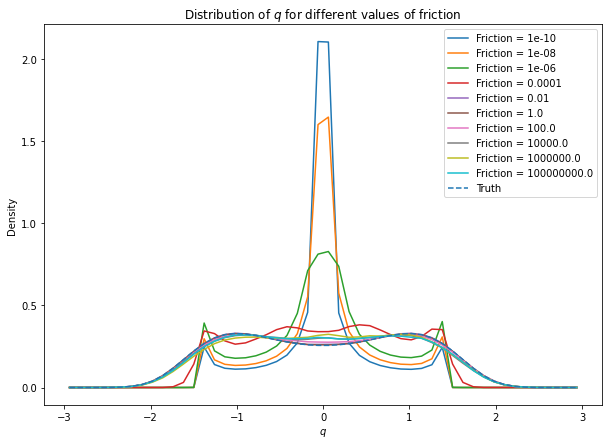

In [32]:
# running 1000 simulations, each taking 100000 steps of size 0.01
OBABO.friction_graph(100000, 0.01, 1000, gammas)

In [33]:
#%run -i Euler_Maruyama.ipynb

In [34]:
#euler_maruyama = Scheme(EM_Step, force_1, U)

In [35]:
#euler_maruyama.friction_graph(1000, 0.1, 1000, gammas)

## Graphing the expected value of U(q)
